#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 10
**CH10B Finding a good deal among hotels with multiple regression**

using the hotels-vienna dataset

version 1.0 2021-05-05

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import sys
from plotnine import *
from mizani.formatters import percent_format
from stargazer.stargazer import Stargazer
import warnings

warnings.filterwarnings("ignore")

In [2]:
path = Path(os.getcwd())
base_dir = path.parent.parent
data_in = os.path.join(str(base_dir) , "da_data_repo/hotels-vienna/clean/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch10-hotels-multiple-reg/")
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")
sys.path.append(func)

In [3]:
from py_helper_functions import *

In [4]:
hotels = pd.read_csv(os.path.join(data_in, "hotels-vienna.csv"))

In [5]:
hotels = hotels.loc[
    lambda x: (x["accommodation_type"] == "Hotel")
    & (x["city_actual"] == "Vienna")
    & (x["stars"] >= 3)
    & (x["stars"] <= 4)
    & (x["price"] <= 600)
    & (x["stars"].notnull())
]

In [6]:
len(hotels)

207

In [7]:
hotels["lnprice"] = hotels["price"].apply(np.log)
hotels["distance2"] = hotels["distance"]
hotels.loc[hotels["distance2"] < 0.05, "distance2"] = 0.05
hotels["lndistance"] = hotels["distance2"].apply(np.log)
hotels["star35"] = (hotels["stars"] == 3.5).map(int)
hotels["star4"] = (hotels["stars"] == 4).map(int)

In [8]:
hotels[["distance", "price", "lnprice"]].describe()

,distance,price,lnprice
count,207.000000,207.000000,207.000000
mean,1.529952,109.975845,4.640219
std,1.161507,42.221381,0.336751
min,0.000000,50.000000,3.912023
25%,0.800000,82.000000,4.406719
50%,1.300000,100.000000,4.605170
75%,1.900000,129.500000,4.863673
max,6.600000,383.000000,5.948035


In [9]:
reg0 = smf.ols("lnprice ~ rating", data=hotels).fit()
reg1 = smf.ols("lnprice ~ distance", data=hotels).fit()
reg2 = smf.ols("lnprice ~ distance + rating", data=hotels).fit()

In [10]:
Stargazer([reg0,reg1,reg2])

In [11]:
y, X = dmatrices(
    "lnprice ~ lspline(distance,[1,4]) + lspline(rating, 3.5) + star35 + star4", hotels
)

reg3 = sm.OLS(y, X).fit()

In [12]:
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     34.76
Date:                Wed, 14 Jul 2021   Prob (F-statistic):           2.19e-31
Time:                        12:06:53   Log-Likelihood:                 14.744
No. Observations:                 207   AIC:                            -13.49
Df Residuals:                     199   BIC:                             13.17
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [13]:
hotels["lnprice_hat"] = reg3.predict(X)

hotels["lnprice_resid"] = hotels["lnprice"] - hotels["lnprice_hat"]

hotels["bestdeals"] = hotels.index.isin(
    hotels["lnprice_resid"].sort_values(ascending=False).tail().index.values
)

In [14]:
reg4 = smf.ols(
    "lnprice ~ lspline(distance,[1,4])",
    data=hotels,
).fit()

In [15]:
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     39.97
Date:                Wed, 14 Jul 2021   Prob (F-statistic):           2.43e-20
Time:                        12:06:53   Log-Likelihood:                -19.879
No. Observations:                 207   AIC:                             47.76
Df Residuals:                     203   BIC:                             61.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [16]:
#refit reg3 for Stargazer

reg3 = smf.ols(
    "lnprice ~ lspline(distance,[1,4]) + lspline(rating, 3.5) + star35 + star4",
    data=hotels,
).fit()

In [17]:
Stargazer([reg1, reg2, reg3, reg4])

### Figure 10.3 ˆy−y plot for log hotel price

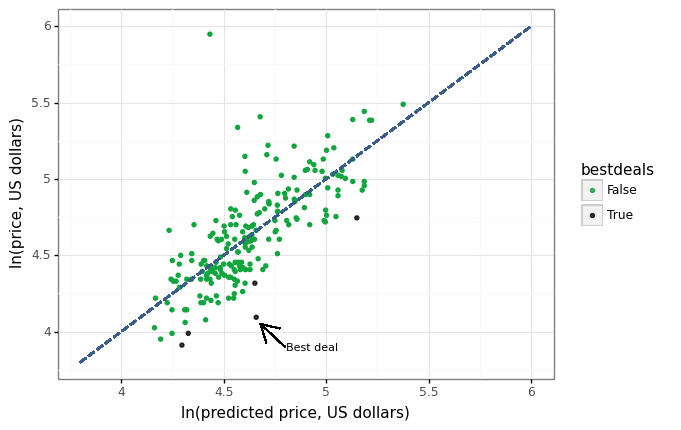

<ggplot: (315044205)>

In [18]:
y_yhat_hotels = (
    ggplot(data=hotels)
    + geom_point(
        aes(x="lnprice_hat", y="lnprice", color="bestdeals"),
        size=1.2,
        alpha=0.8,
    )
    + geom_segment(
        aes(x=3.8, y=3.8, xend=6, yend=6), size=0.8, color=color[0], linetype="dashed"
    )
    + labs(x="ln(predicted price, US dollars) ", y="ln(price, US dollars)")
    + scale_colour_manual(name="", values=[color[1], "black"])
    + geom_segment(aes(x=4.8, y=3.9, xend=4.68, yend=4.05), arrow=arrow())
    + annotate("text", x=4.93, y=3.9, label="Best deal", size=8)
    + theme_bw()
)
y_yhat_hotels

### Residual plot - not in the book

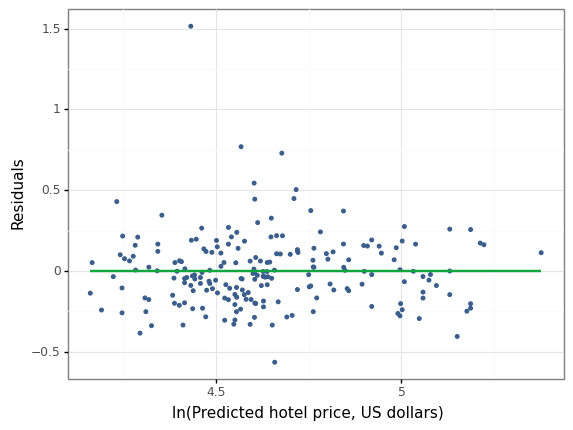

<ggplot: (315176186)>

In [19]:
y_hat_resid_hotels = (
    ggplot(data=hotels)
    + geom_point(
        aes(x="lnprice_hat", y="lnprice_resid"),
        color=color[0],
        size=1,
        fill=color[0],
        alpha=0.6,
    )
    + geom_smooth(
        aes(x="lnprice_hat", y="lnprice_resid"),
        method="lm",
        color=color[1],
        size=1,
        se=False,
    )
    + labs(x="ln(Predicted hotel price, US dollars)", y="Residuals")
    + scale_colour_manual(name="", values=[color[1], "black"])
    + theme_bw()
)
y_hat_resid_hotels